# Py/R: Multitasking Risk Pricing Using Deep Learning

By Jacky Poon. Originally published in Actuaries Digital as [Analytics Snippet: Multitasking Risk Pricing Using Deep Learning](https://www.actuaries.digital/2018/08/23/analytics-snippet-multitasking-risk-pricing-using-deep-learning/).

So, you have been asked to build a risk premium pricing model for a motor portfolio - a classic GI problem. 

The standard approach would be to:
* Split the claims into perils, or peril groups based on the cause of loss
* Build separate generalised linear models (GLMs) of the frequency and severity of each peril group.
* Calibrate non-linear effects such as curves and interactions (typically manually).

This approach has its challenges. Key limitations would be:
* Choice of peril groups - finer groups increases granularity, but decreases the data available to each model as they are estimated independently
* In the event that frequency and severity are correlated, there is no clear way to model expected cost other than to create a third, independent Tweedie model
* Challenges in finding the right interactions and curves based on the data.

What if, there was a model structure that:
* Can estimate multiple frequency, severity and expected cost responses in a single model
* While sharing commonalities between those outputs
* Is a [universal approximator](https://en.wikipedia.org/wiki/Universal_approximation_theorem) so non-linear effects can be captured automatically
* Can be expanded to use freeform text, photos, voice, or time series data as inputs?

In this analytics snippet, we introduce <b>multi-task deep learning for general insurance risk pricing</b>.

We apply the flexible structure of deep learning - in particular, multi-task learning, a variation where the model has multiple outputs - to predict all of the expected claims outcomes in a general insurance scenario.

## Python and R
The tutorial below includes code to implement the model, with the option for readers to pick from Python or R.

Python is generally considered to be better for neural network modelling due to its better support for deep learning packages. Consequently it is the recommended language for this snippet and only the output for the Python version is shown. However, R code that implements similar functionality is also included for those who prefer to work exclusively in R. If you are completely new to Python, and feel that the code below a bit intimidating, I would recommend the excellent free introductory tutorial by [DataCamp](https://www.datacamp.com/courses/intro-to-python-for-data-science). 

Python is free software - you can download it and run it on your pc - either through a distribution which comes with an installer and complete set of packages like [Anaconda](https://www.anaconda.com/download/) or a more barebones download directly from [python.org](https://www.python.org/downloads/). Alternatively, you can also run it online through a web "notebook" interface which works on any device including phones and tablets. Free services includes [Google Colaboratory](https://colab.research.google.com/) which links in with Google Drive, [Microsoft Azure Notebooks](https://notebooks.azure.com/) which links in with OneDrive, and [Binder](https://mybinder.org/) which links to Github.

## Packages
This example uses keras with Google's tensorflow library to build the neural networks:
* [keras](https://keras.io/), a neural network framework, and 
* [tensorflow](https://www.tensorflow.org/) Google's computational library which works with Keras.

Other standard packages include:
* [pandas](https://pandas.pydata.org/), the "panel data" data frames library for python, 
* [numpy](http://www.numpy.org/) for array based calculations,
* [sci-kit learn](http://scikit-learn.org/stable/index.html), a framework for machine learning, 
* [jupyter](http://jupyter.org/), a common tool to viewing and reproducing code 
* [pydot](https://github.com/erocarrera/pydot), required to plot the neural network graph, which relies on:
* [graphwiz](https://graphviz.gitlab.io/_pages/Download/Download_windows.html). For Graphwiz installation on Windows, you may need to manually add the "bin" subfolder of the installed folder location to your PATH for pydot to access.

#### Python

In [1]:
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, Dense, Reshape, concatenate
from keras.models import Model
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split

from IPython.display import SVG

%matplotlib inline

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### R
In R, we can interface with keras as well using one of two packages, either through Rstudio's ["keras"](https://keras.rstudio.com/) or alternatively ["kerasR"](https://cran.r-project.org/web/packages/kerasR/vignettes/introduction.html). The R code below uses the "keras" package. See [website](https://keras.rstudio.com/) for installation instructions.

```r
library(keras)
library(dplyr)
```

## Reproducibility
Neural network trainings include randomisation in the starting conditions and evolution.

Including the code below (Python only) will fix the random number generation to a specific value by defining the ‘seeds’ ahead of model fitting, which should lead to a model result that is very close to the results in the article. However, calculations may run slower when fixing seeds.

#### Python (Optional)

In [2]:
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Data

Unfortunately, there are very few public insurance datasets that have a great amount of detail. The example dataset we will use is the "Third party motor insurance claims in Sweden in 1977", a real-life motor insurance dataset. More information on the dataset can be found [here](http://www.statsci.org/data/general/motorins.html).

This has no perils to split by, however we will create a deep learning model that estimates both claim frequency and average risk premium in a single model. First we will read in and inspect the data:

#### Python

In [3]:
df = pd.read_csv("http://www.statsci.org/data/general/motorins.txt", sep='\t') \
    .assign(
        frequency = lambda x: x.Claims / x.Insured,
        severity =  lambda x: np.where(x.Claims == 0, 0, x.Payment / x.Claims),
        risk_premium = lambda x: x.Payment / x.Insured
    )

In [4]:
df.head()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,frequency,severity,risk_premium
0,1,1,1,1,455.13,108,392491,0.237295,3634.175926,862.371191
1,1,1,1,2,69.17,19,46221,0.274686,2432.684211,668.223218
2,1,1,1,3,72.88,13,15694,0.178375,1207.230769,215.340285
3,1,1,1,4,1292.39,124,422201,0.095946,3404.846774,326.682348
4,1,1,1,5,191.01,40,119373,0.209413,2984.325000,624.956809


#### R

```r
df <- read.csv(url("http://www.statsci.org/data/general/motorins.txt"), sep="\t") %>%
  mutate(frequency = Claims / Insured, 
         severity = ifelse(Claims == 0, 0, Payment / Claims), 
         risk_premium = Payment / Insured)
```

```r
head(df)
```

Next, we will split the dataset up into a training dataset and set aside a test dataset for validating our model.

This will also conveniently randomise the ordering of the data. Neural networks train on batches of data records, so we would prefer the data to be in a random order so that each batch is a representative sample rather than the neatly sorted table above.

#### Python

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=12345)

#### R

```r
train_ind <- sample(seq_len(nrow(df)), size = floor(0.8 * nrow(df)))

train <- df[train_ind,]
test  <- df[-train_ind,]
```

To rescale the output data, the average frequency, severity and risk premium in the training dataset is calculated.

#### Python

In [6]:
totals = train.loc[:, ["Insured", "Claims", "Payment"]].agg('sum') 

In [7]:
train_average_frequency = totals["Claims"] / totals["Insured"]
train_average_severity = totals["Payment"] / totals["Claims"]
train_average_risk_premium = totals["Payment"] / totals["Insured"]

print(train_average_frequency, train_average_severity, train_average_risk_premium)

0.04749109486158422 4959.405313081085 235.52758818057862


#### R

```r
summary <- train %>% summarise(
  train_average_frequency = sum(Claims) / sum(Insured),
  train_average_severity = sum(Payment) / sum(Claims),
  train_average_risk_premium = sum(Payment) / sum(Insured))
  
summary
```

## Neural Network

Designing a neural network architecture is analogous to piecing some building blocks together. We will design the model using the functional API of Keras, which allows us to composite neural network layers to form our model architecture.

### Embeddings
When fitting statistical models, categorical variables typically need to be converted to a series of numerical vectors. Often for GLMs, [indicator variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) are set. 

In deep learning we can use an "embedding" encoding, which will encode the sequence down to a small number of vectors and gets fit as part of the model. We will do this for zone and make.

#### Python

In [8]:
zone_input = Input(shape=(1,), name='zone_input')
make_input = Input(shape=(1,), name='make_input')

#### R

```r
zone_input = layer_input(shape=c(1), name='zone_input')
make_input = layer_input(shape=c(1), name='make_input')
```

According to Google's Tensorflow guide, a rough rule of thumb for setting the size of the output vector of an embedding would be the quartic root (^0.25) of the number of categories. However since the the number of categories is so small, we will just keep to output dimensions of 2.

#### Python

In [9]:
zone_embedding = Embedding(output_dim=2, input_dim=7)(zone_input)
zone_embedding = Reshape(target_shape=(2,))(zone_embedding)
                         
make_embedding = Embedding(output_dim=2, input_dim=9)(make_input)
make_embedding = Reshape(target_shape=(2,))(make_embedding)

#### R

```r
zone_embedding = layer_embedding(output_dim=2, input_dim=7)(zone_input) %>%
  layer_reshape(target_shape=c(2))

make_embedding = layer_embedding(output_dim=2, input_dim=9)(make_input) %>% 
  layer_reshape(target_shape=c(2))
```

### Other inputs
Kilometres and Bonus already have an implicit relationship between the value of the factor and the meaning - i.e. higher Kilometres factors represents a higher amount of kilometres driven, so we will put in the data as is. 

#### Python

In [10]:
kilometres_input = Input(shape=(1,), name='kilometres_input')
bonus_input = Input(shape=(1,), name='bonus_input')

#### R

```r
kilometres_input = layer_input(shape=c(1), name='kilometres_input')
bonus_input = layer_input(shape=c(1), name='bonus_input')
```

We then concatenate the inputs together.

#### Python

In [11]:
x = concatenate([zone_embedding, make_embedding, kilometres_input, bonus_input])

#### R

```r
x = layer_concatenate(c(zone_embedding, make_embedding, kilometres_input, bonus_input))
```

### Dense layers
Next we get to the actual "brains" of the deep learning model. For the example we will keep it simple with a sequential series of dense layers, however it is possible to use more complex structures or choices of layers which may improve prediction performance.

#### Python

In [12]:
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

#### R

```r
x = x %>% layer_dense(64, activation='relu') %>% 
  layer_dense(64, activation='relu') %>%
  layer_dense(64, activation='relu')
 ```

Here we have added three hidden "layers", with each layer consisting of 64 nodes (or "neurons"). 

This should give enough flexibility for non-linear effects and interactions, while not adding too much complexity, given the scale of the dataset. 

Each node uses a [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), or "ReLU" activation function, which is akin to a truncated linear model, with the truncation giving the overal network its non-linear capabilties.   

Ideas to potentially explore with the goal of improving predictivness include adjusting the number of layers, or adding drop out, batch normalisation, or skip layer structures into the model.

The deep learning approach also opens the possibility of using more complex data such as images as inputs into the model. Even a small image dataset can be leveraged to provide insights by connecting it to one of many publically available pre-trained image recognition networks and then "fine-tuned" to provide insights into your motor risk rating.

### Output
Finally, we add the output regression layer that describes our three outcomes of interest:

#### Python

In [13]:
frequency_output = Dense(1, activation='relu', name='frequency')(x)
severity_output = Dense(1, activation='relu', name='severity')(x)
risk_premium_output = Dense(1, activation='relu', name='risk_premium')(x)

#### R

```r
frequency_output    = x %>% layer_dense(1, activation='relu', name='frequency')
severity_output     = x %>% layer_dense(1, activation='relu', name='severity')
risk_premium_output = x %>% layer_dense(1, activation='relu', name='risk_premium')
```

More outputs can be added - if there are multiple risk perils, you could then include each of the frequency, severity and risk premium values as an additional output. 

It is also possible to include input variables as outputs to infer missing values or just help the model "understand" the features - in fact the winning solution of a claims prediction Kaggle competition heavily used denoising autoencoders together with model stacking and ensembling - read more [here](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629).

### Model Definition


#### Python

In [14]:
model = Model(inputs=[zone_input, make_input, kilometres_input, bonus_input], 
              outputs=[frequency_output, severity_output, risk_premium_output])

#### R

```r
model = keras_model(inputs=c(zone_input, make_input, kilometres_input, bonus_input), 
              outputs=c(frequency_output, severity_output, risk_premium_output))
```

The standard poisson will be used for frequency. 
A simple mean squared error will be used for risk premium. 

Keras allows definition of custom loss functions, so it would be possible to improve this by potentially including a gamma claim size (as suggested by the paper from which the dataset comes from) and a tweedie risk premium model. 

However for this snippet we will just keep it simple and use the available standard losses.

#### Python

In [15]:
model.compile(optimizer='adam',
              loss={'risk_premium': 'mean_squared_error', 'frequency': 'poisson', 'severity': 'mean_squared_logarithmic_error'}, 
              loss_weights={'risk_premium': 1.0, 'frequency': 1.0, 'severity': 1.0})

#### R

```r
model %>% compile(optimizer='adam',
              loss=list(risk_premium='mean_squared_error', 
                        frequency='poisson', 
                        severity='mean_squared_logarithmic_error'), 
              loss_weights=list(risk_premium= 1.0, frequency= 1.0, severity= 1.0))
```

This is how our model looks like diagrammatically:

#### Python

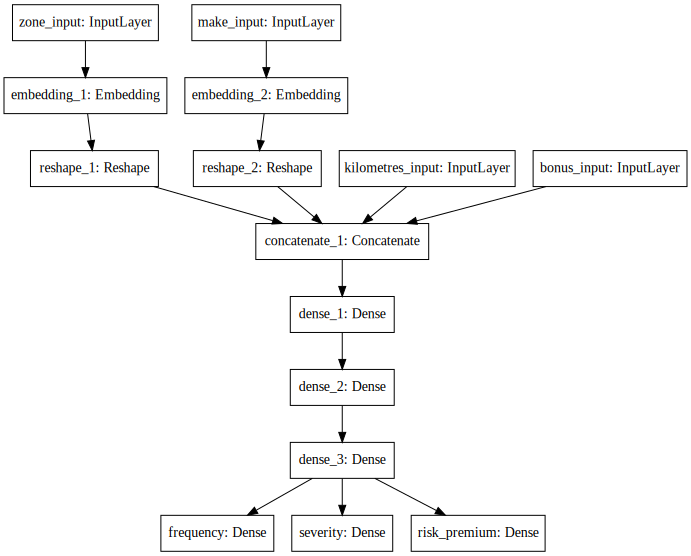

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### R (text summary only)

```r
summary(model)
```

### Flexibility in Inputs and Outputs
While it is not possible with our example dataset based on historical data, it is worth noting the flexibility that a neural network can give to your model inputs - for example:
* images (e.g. photos of the vehicle),
* freeform text descriptions (e.g. claims diary of accident history),
* time series (e.g. driving behaviours)

These can all be included as predictors if they were available - leveraging image recognition and natural language processing models and other advances in deep learning.

Outputs can also be the images, freeform texts or time series. They can also include the missing data in inputs - for example, the first place solution in the [Porto Seguro Kaggle data mining competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629) was based on auto-encoders which predicts the inputs as outputs.

### Fit
Fitting the model. Some things to note are:
* keras factors for embeddings count from 0, 1, 2... but our data is set up as 1, 2 3 so we need to subtract 1 from each predictor,
* sample weights are set individually - frequency and risk premium use the same exposure weights, but had we included claim size, that would use claim count as the weight,
* do some basic normalising - on the Bonus and Kilometres inputs and particularly on the outputs to get frequency and risk premium to be in the same scale.

#### Python

In [17]:
def InputDataTransformer(x):
    return {
    'kilometres_input': (x.Kilometres.values - 1) / 5,
    'zone_input': x.Zone.values - 1,
    'bonus_input': (x.Bonus.values - 1) / 7,
    'make_input': x.Make.values - 1}

In [18]:
model.fit(
    InputDataTransformer(train),
    {'frequency': train.frequency.values / train_average_frequency,
     'severity': train.severity.values / train_average_severity,
     'risk_premium': train.risk_premium.values / train_average_risk_premium}, 
    sample_weight={
        'frequency': train.Insured.values,
        'severity': train.Claims.values,
        'risk_premium': train.Insured.values
    },
    epochs=40, batch_size=32)

Epoch 1/40
1745/1745 [==============================] - 1s 378us/step - loss: 2576.4842 - frequency_loss: 1495.8723 - severity_loss: 15.2120 - risk_premium_loss: 1065.3999
Epoch 2/40
1745/1745 [==============================] - 0s 75us/step - loss: 1579.1398 - frequency_loss: 1146.6263 - severity_loss: 2.6367 - risk_premium_loss: 429.8768
Epoch 3/40
1745/1745 [==============================] - 0s 69us/step - loss: 1286.9174 - frequency_loss: 1045.1732 - severity_loss: 3.3395 - risk_premium_loss: 238.4046
Epoch 4/40
1745/1745 [==============================] - 0s 80us/step - loss: 1211.8722 - frequency_loss: 1020.3159 - severity_loss: 3.3936 - risk_premium_loss: 188.1627
Epoch 5/40
1745/1745 [==============================] - 0s 69us/step - loss: 1176.7366 - frequency_loss: 1008.0177 - severity_loss: 3.0215 - risk_premium_loss: 165.6974
Epoch 6/40
1745/1745 [==============================] - 0s 57us/step - loss: 1160.6227 - frequency_loss: 1003.7292 - severity_loss: 2.5391 - risk_premiu

#### R

```r
InputDataTransformer <- function(x){
  list(
    kilometres_input= (x$Kilometres - 1) / 5,
    zone_input= (x$Zone - 1),
    bonus_input= (x$Bonus - 1) / 7,
    make_input= x$Make - 1
  )}
```

```r
model %>% fit(
  x=InputDataTransformer(train),
  y=list(
    frequency=train$frequency / summary$train_average_frequency,
    severity=train$severity / summary$train_average_severity,
    risk_premium=train$risk_premium / summary$train_average_risk_premium),
  sample_weight=list(
    frequency=train$Insured,
    severity=train$Claims,
    risk_premium=train$Insured),
  epochs=40, batch_size=32)
```

## Model Validation

We will now apply this to the test set to see how well the model has worked.

The plots below show the observations ordered from least risky to most risky, with the modelled vs actual frequency and risk premiums, for the training and test sets.

#### Python

In [19]:
def predict_and_plot(df, train_average_frequency, train_average_risk_premium):
    model_frequency, model_severity, model_risk_premium = model.predict(InputDataTransformer(df))

    # Reverse the normalisation
    # Score, sort by lowest to higher
    df_new = df.assign(model_frequency = model_frequency * train_average_frequency, 
                       model_risk_premium = model_risk_premium * train_average_risk_premium) \
        .assign(model_payment = lambda x: x.model_risk_premium * x.Insured,
                model_claim_count = lambda x: x.model_frequency * x.Insured) \
        .sort_values(by=['model_frequency']) \
        .assign(model_claim_count_band = lambda x: np.floor(x.model_claim_count.cumsum() / x.model_claim_count.agg('sum') * 10) / 10) \
        .sort_values(by=['model_risk_premium']) \
        .assign(model_payment_band = lambda x: np.floor(x.model_payment.cumsum() / x.model_payment.agg('sum') * 10) / 10)
        
    # Summarise and plot frequency by weighted decile rank
    df_new.loc[:,['model_claim_count_band', 'Insured', 'Claims', 'model_claim_count']] \
        .groupby('model_claim_count_band') \
        .agg('sum') \
        .assign(model_frequency = lambda x: x.model_claim_count / x.Insured,
               actual_frequency = lambda x: x.Claims / x.Insured) \
        .loc[:,['model_frequency', 'actual_frequency']] \
        .plot.bar()
                
    # Summarise and plot risk premium by weighted decile rank
    df_new.loc[:,['model_payment_band', 'Insured', 'Payment', 'model_payment']] \
        .groupby('model_payment_band') \
        .agg('sum') \
        .assign(model_risk_premium = lambda x: x.model_payment / x.Insured,
               actual_risk_premium = lambda x: x.Payment / x.Insured) \
        .loc[:,['model_risk_premium', 'actual_risk_premium']] \
        .plot.bar()
    
    return df_new

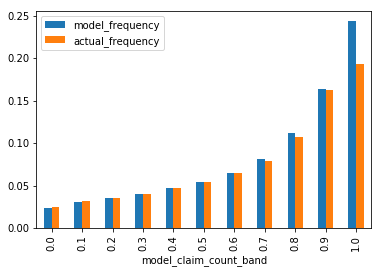

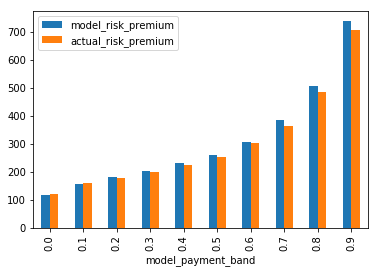

In [20]:
train = predict_and_plot(train, train_average_frequency, train_average_risk_premium)

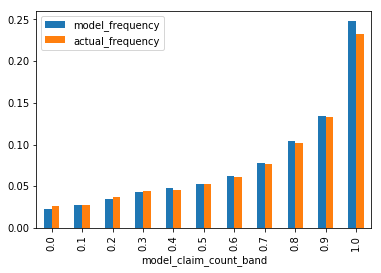

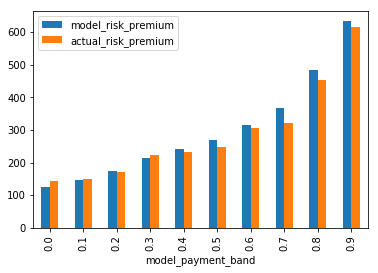

In [21]:
test = predict_and_plot(test, train_average_frequency, train_average_risk_premium)

#### R

```r
predict_and_plot <- function(df, train_average_frequency, train_average_risk_premium){
  predictions <- model %>% predict(InputDataTransformer(df)) %>% as.data.frame()
  colnames(predictions) <- c("model_frequency", "model_severity", "model_risk_premium")
  
  # Reverse the normalisation
  df_new <- df %>% cbind(predictions) %>%
    mutate(model_frequency = model_frequency * train_average_frequency,
           model_risk_premium = model_risk_premium * train_average_risk_premium) %>%
    mutate(model_payment = model_risk_premium * Insured,
           model_claim_count = model_frequency * Insured)
  
  df_summary <- df_new %>%
    summarise(model_claim_count_sum = sum(model_claim_count),
              model_payment_sum = sum(model_payment))
  
  # Score, sort by lowest to higher
  df_new <- df_new %>%
    arrange(model_frequency) %>%
    mutate(model_claim_count_band = floor(cumsum(model_claim_count) / df_summary$model_claim_count_sum * 10) / 10) %>%
    arrange(model_risk_premium) %>%
    mutate(model_payment_band = floor(cumsum(model_payment) / df_summary$model_payment_sum * 10) / 10)
  
  # Summarise and plot frequency by weighted decile rank
  df_new %>% group_by(model_claim_count_band) %>%
    summarise(model_frequency = sum(model_claim_count) / sum(Insured),
              actual_frequency = sum(Claims) / sum(Insured)) %>%
    select(-model_claim_count_band) %>% as.matrix() %>% t() %>%
    barplot(xlab = "Frequency Decile", ylab="Frequency", beside = TRUE)

  # Summarise and plot risk premium by weighted decile rank
  df_new %>% group_by(model_payment_band) %>%
    summarise(model_risk_premium = sum(model_payment) / sum(Insured),
              actual_risk_premium = sum(Payment) / sum(Insured)) %>%
    select(-model_payment_band) %>% as.matrix() %>% t() %>%
    barplot(xlab = "Risk Premium Decile", ylab="Risk Premium", beside = TRUE)

  df_new
}

train = predict_and_plot(train, summary$train_average_frequency, summary$train_average_risk_premium)
test = predict_and_plot(test, summary$train_average_frequency, summary$train_average_risk_premium)
```

Neural networks can be fragile. Data needs to be transformed in the right way, and the model architecture and optimiser settings can all have impact on the model performance. This makes validation tests such as the test data testing above especially important. 

The model appears to be performing well even on the test data set, with the best and worse having a wide differential in predicted outcomes, and actual matching well to those predictions. Try and see the variations if you remove the reproducible constraint at the start and train it multiple times. Does the model fit well every time?

In the event a neural network model behaves oddly, some good resources for diagnosing issues can be found [here](http://theorangeduck.com/page/neural-network-not-working) and [here](https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607).

## Run this code in your browser!

All the Python and R code from this snippet can be run interactively in your browser. 

For Python, use the rocket icon at the top of the page and select Colab (fairly quick, requires Google account) or Live Code (slower).

Alternatively, you can use the links below:

* [Python](https://mybinder.org/v2/gh/ActuariesInstitute/analytics-snippet-multitask/master?filepath=Multitasking%20Risk%20Pricing.ipynb)
* [R](https://mybinder.org/v2/gh/ActuariesInstitute/analytics-snippet-multitask/master?filepath=multitask_risk_pricing.R&urlpath=rstudio)

Some loading time is expected with the latter, as the [Binder](https://mybinder.org/) server needs to load and start up a virtual machine with all the packages and code installed.

## Afterward
Often media article tends to describe "AI" in science-fiction or occult terms, but it is important to recognise that it is only a particular class of models. Just like other models, actuaries should ask tough questions about its appropriateness - such as on the quality of data inputs, the understanding of outliers, and the distribution assumptions.

It is also a model with some very useful properties. As we have seen above, a fully functional, multi-tasking neural network for potentially automating general insurance pricing is possible in only around 100 lines of Python or R code. It is not too hard for actuaries with good grounding in statistics to learn, and perhaps it may be useful for your next project!

To learn more on neural networks from first principles, Google's [Intro to Deep Learning](https://www.udacity.com/course/deep-learning--ud730) seems like a good choice. Alternatively, for those who prefer to plunge straight into applications, there is the [fast.ai course](http://course17.fast.ai/) - the older v1 of the course uses Keras similar to this tutorial. 